In [1]:
import ast
import os
import glob
import numpy as np
import datetime
import xarray as xr
import nc_time_axis
import itertools
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cftime
%matplotlib inline

In [2]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    'RCP8.5': ('RCP',2092,'rcp'), 
    'SAI2050': ('SAI',2092,'sai')
}


fname = "RCP.started_2002.001/TCseeds_tracker_results.ref.started_2002.001.nc"

ds = xr.open_dataset(fname, decode_cf=False)

times = ds.TC_tracks.isel(data=0)

v = ds
for i,(desc) in enumerate(v.data.description):
    shortname = desc[:desc.index(':')]
    v[shortname] = v.TC_tracks.isel(data=i).assign_attrs(
        ast.literal_eval(desc[desc.index(':')+1:]))
    v[shortname].data[v[shortname]>1e30] = np.nan
time = v.time.copy()
tmask = np.isnan(time)
time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
v['year'] = time.dt.year.where(~tmask, np.nan)
v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
v['PRECT'].attrs.update({'units':'mm/hour'})
ds = v

Text(1.0, 1.0, 'n = 4690')

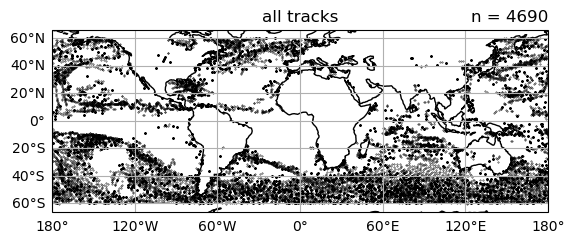

In [3]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(ds.lon, ds.lat, c='k', s=0.1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=['bottom','left'])
ax.set_title(f"all tracks")
ax.set_title(f"n = {ds.id.size}", loc='right')

Text(0.5, 1.0, 'number of tracks')

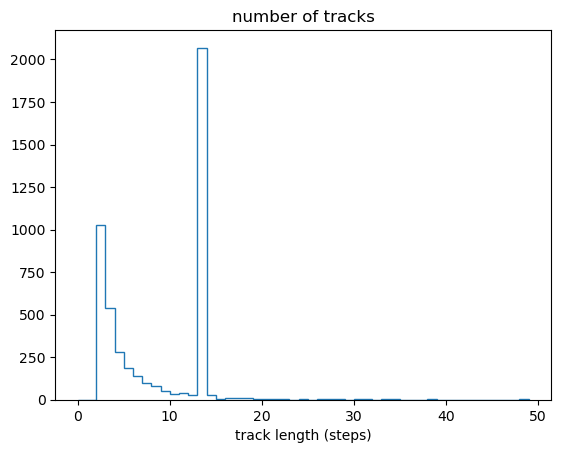

In [4]:
tracksize = ds.lon.notnull().sum('dtime')
hist, bins = np.histogram(tracksize, bins=range(ds.dtime.size+1))
plt.stairs(hist, bins)
plt.xlabel('track length (steps)')
plt.title('number of tracks')

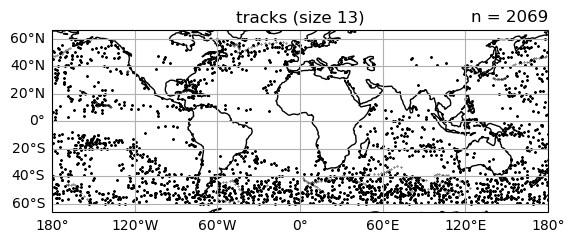

In [6]:
dsi = ds.where(tracksize==13, drop=True)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(dsi.lon, dsi.lat, c='k', s=0.1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=['bottom','left'])
ax.set_title(f"tracks (size 13)")
_=ax.set_title(f"n = {dsi.id.size}", loc='right')

In [22]:
print(dsi.dtime.size*dsi.id.size)
((dsi.diff('dtime') == 0) | (dsi.diff('dtime').isnull())).sum()

101381


<xarray.Dataset>
Dimensions:    ()
Data variables: (12/16)
    TC_tracks  int64 1261260
    num_days   int64 0
    time       int64 99060
    lon        int64 99076
    lat        int64 99108
    PSL        int64 99060
    ...         ...
    SSTmon     int64 99091
    RV         int64 99060
    Vshear     int64 99060
    PRECT      int64 99060
    TEMP       int64 99060
    year       int64 99312

### 16-10-2025

In [3]:
fname = "../../tracker/jobs/test_tracking/TC_tracker_results.ref.started_2002.001.seeds.nc"
ds = xr.open_dataset(fname, decode_timedelta=True)

In [48]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    # 'RCP8.5': ('RCP',2092,'rcp'), 
    # 'SAI2050': ('SAI',2092,'sai')
}

ds = {exp: [] for exp in open_kwargs}
ds['Reference'] = xr.open_dataset(fname, decode_cf=False)

for k,v in ds.items():
    for i,(desc) in enumerate(v.data.description):
        shortname = desc[:desc.index(':')]
        v[shortname] = v.TC_tracks.isel(data=i)
        v[shortname].data[v[shortname]>1e30] = np.nan
        try:
            v[shortname] = v[shortname].assign_attrs(
            ast.literal_eval(desc[desc.index(':')+1:]))
        except:
            print(f"{shortname}: Could not convert attributes to python code: {desc[desc.index(':')+1:]}")
        
    time = v.time.copy()
    time -= 0.0625 # set to center of CESM time bounds (only for year determination)
    tmask = np.isnan(time)
    time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
    v['year'] = time.dt.year.where(~tmask, np.nan)
    v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
    v['PRECT'].attrs.update({'units':'mm/hour'})


# check for gaps in track (i.e. last numeric value should be next to first null value)
for tid in ds['Reference'].id:
    lons = ds['Reference'].lon.sel(id=tid).data
    if not (np.searchsorted(np.isnan(lons), False, side='right') == np.searchsorted(np.isnan(lons), True, side='left')):
        print(f"WARNING: gaps in track {id=}\n{lons=}")

SST: Could not convert attributes to python code: {'long_name': 'Surface Potential Temperature', 'units': 'degC', 'coordinates': 'TLONG TLAT time', 'grid_loc': '2110', 'cell_methods': 'time: mean', '_FillValue': np.float32(9.96921e+36), 'missing_value': np.float32(9.96921e+36)}


In [2]:
def fix_longitude_jumps(lons, thresh=10):
    """Remove longitude jumps when crossing the Greenwich Meridian
    
    lons (1-d): longitudes
    thresh : maximum expected absolute longitude change per step
    """
    newlons = np.array(lons, copy=True)
    if any(np.abs(np.diff(lons))>thresh):
        for l in range(1,len(newlons)):
            dlon = newlons[l] - newlons[l-1]
            inc = np.sign(int(abs(dlon)>thresh) * dlon)
            if inc != 0:
                newlons[l] = newlons[l] - inc * 360
    return newlons


def track_segments(ds, clevs, x='lon', y='lat', c='PSL', reverse=True):
    """Split all tracks in ds into segments of equal intensity

    input:
    ds : xr.Dataset
        the dataset containing TC tracks
    clevs : Iterable[Numeric]
        levels (bin edges) used to discretize 'c' and segment track data
    x : str
        name of longitude variable
    y : str
        name of latitude variable
    c : str
        name of variable that will be used to segment the track data
    reverse : bool
        by default, track segments having lower values of 'c' are
        output first, this can be reversed by setting reverse=True

    returns:
    """
    ds = ds[[x,y,c]]
    cvals = 0.5 * (clevs[1:] + clevs[:-1])
    
    segments = []
    for tid in ds.id.data:
        # remove longitude jumps when crossing the Greenwich Meridian
        track = ds.sel(id=tid).dropna('dtime')
        track[x].data = fix_longitude_jumps(track[x].data)
        
        # groupby color level consecutively along track
        clev_ids = np.searchsorted(clevs, track[c])
        comb = zip(clev_ids, track[x].data, track[y].data)
        gb = itertools.groupby(comb, key=lambda x: x[0])
        track_segs = [[k,np.vstack(list(dt))[:,1:]] for k,dt in gb]
    
        # insert midway points for smooth joins of segments
        for s,(seg1, seg2) in enumerate(itertools.pairwise(track_segs)):
            ival = np.mean([seg1[1][-1],seg2[1][0]], axis=0)
            track_segs[s][1] = np.vstack([track_segs[s][1], ival])
            track_segs[s+1][1] = np.vstack([ival,track_segs[s+1][1]])
        
        segments += track_segs

    segments = sorted(segments, key=lambda x:x[0], reverse=reverse)
    gb = itertools.groupby(segments, key=lambda x:x[0])
    segments = {c:[segs for _,segs in grp] for c,grp in gb}
    return segments

Text(0.5, 1.0, 'Sea level pressure [hPa]')

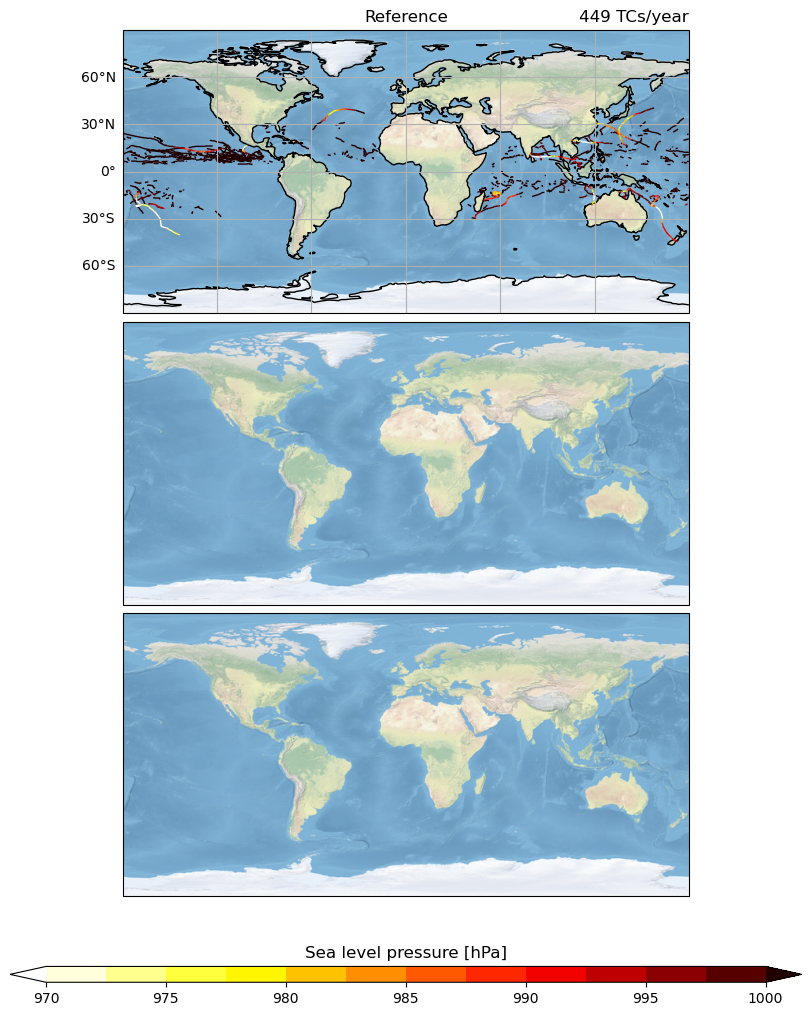

In [59]:

################### track figure #######################

vmin, vmax = 970, 1000
Nv = round((vmax-vmin)/2.5)+1
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')

fig,axs = plt.subplots(3,1,figsize=(8,10), constrained_layout=True, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0),
                                   'xmargin':0.01, 'ymargin':0.01})
for exp, ax in zip(ds, axs):
    #dsi = select_region(ds[exp], dom)
    dsi = ds[exp]
    segments = track_segments(dsi, clevels)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(), capstyle='butt'))
    ax.set_title(exp)
    ax.set_title(f'{dsi.id.size/ds[exp].num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

for ax in axs: # must be after plotting to prevent setting a global view
    ax.stock_img()

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
cb.ax.set_title('Sea level pressure [hPa]')

#savefig(fig, fname, transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'TC seed wind speed (cut off should be 17 m/s)')

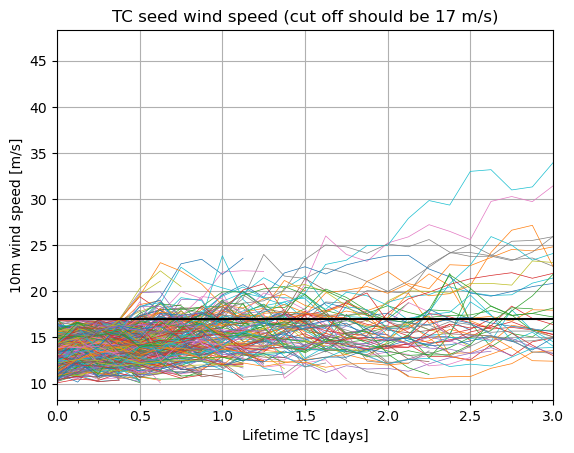

In [82]:
for tid in ds['Reference'].id:
    ds['Reference'].U10.sel(id=tid).plot(lw=0.5)
plt.plot([0,21],[17,17], c='k')
_=plt.xticks(np.arange(0,21,1/8), minor=True)
plt.xlim([0,3])
plt.grid()
plt.title("TC seed wind speed (cut off should be 17 m/s)")

In [83]:
ds['Reference'].U10.max('dtime').argmax('id')

<xarray.DataArray 'U10' ()> Size: 8B
array(249)

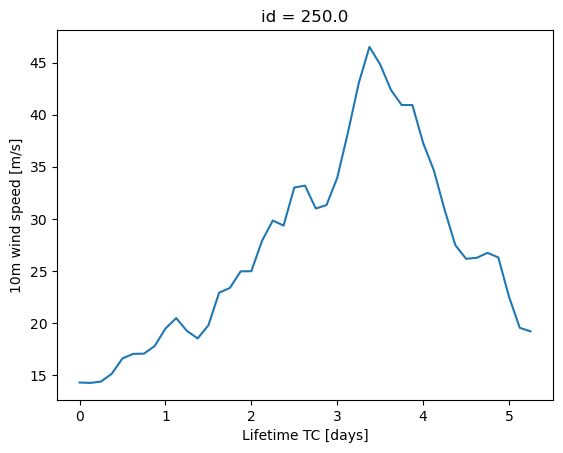

In [84]:
U10 = ds['Reference'].isel(id=249).U10
U10.plot()

### attempt 2

In [3]:
fname = "../../tracker/jobs/test_tracking/TC_tracker_results.ref.started_2002.001.seeds.nc"
ds = xr.open_dataset(fname, decode_timedelta=True)

In [4]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    # 'RCP8.5': ('RCP',2092,'rcp'), 
    # 'SAI2050': ('SAI',2092,'sai')
}

ds = {exp: [] for exp in open_kwargs}
ds['Reference'] = xr.open_dataset(fname, decode_cf=False)

for k,v in ds.items():
    for i,(desc) in enumerate(v.data.description):
        shortname = desc[:desc.index(':')]
        v[shortname] = v.TC_tracks.isel(data=i)
        v[shortname].data[v[shortname]>1e30] = np.nan
        try:
            v[shortname] = v[shortname].assign_attrs(
            ast.literal_eval(desc[desc.index(':')+1:]))
        except:
            print(f"{shortname}: Could not convert attributes to python code: {desc[desc.index(':')+1:]}")
        
    time = v.time.copy()
    time -= 0.0625 # set to center of CESM time bounds (only for year determination)
    tmask = np.isnan(time)
    time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
    v['year'] = time.dt.year.where(~tmask, np.nan)
    v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
    v['PRECT'].attrs.update({'units':'mm/hour'})


# check for gaps in track (i.e. last numeric value should be next to first null value)
for tid in ds['Reference'].id:
    lons = ds['Reference'].lon.sel(id=tid).data
    if not (np.searchsorted(np.isnan(lons), False, side='right') == np.searchsorted(np.isnan(lons), True, side='left')):
        print(f"WARNING: gaps in track {id=}\n{lons=}")

Text(0.5, 1.0, 'Sea level pressure [hPa]')

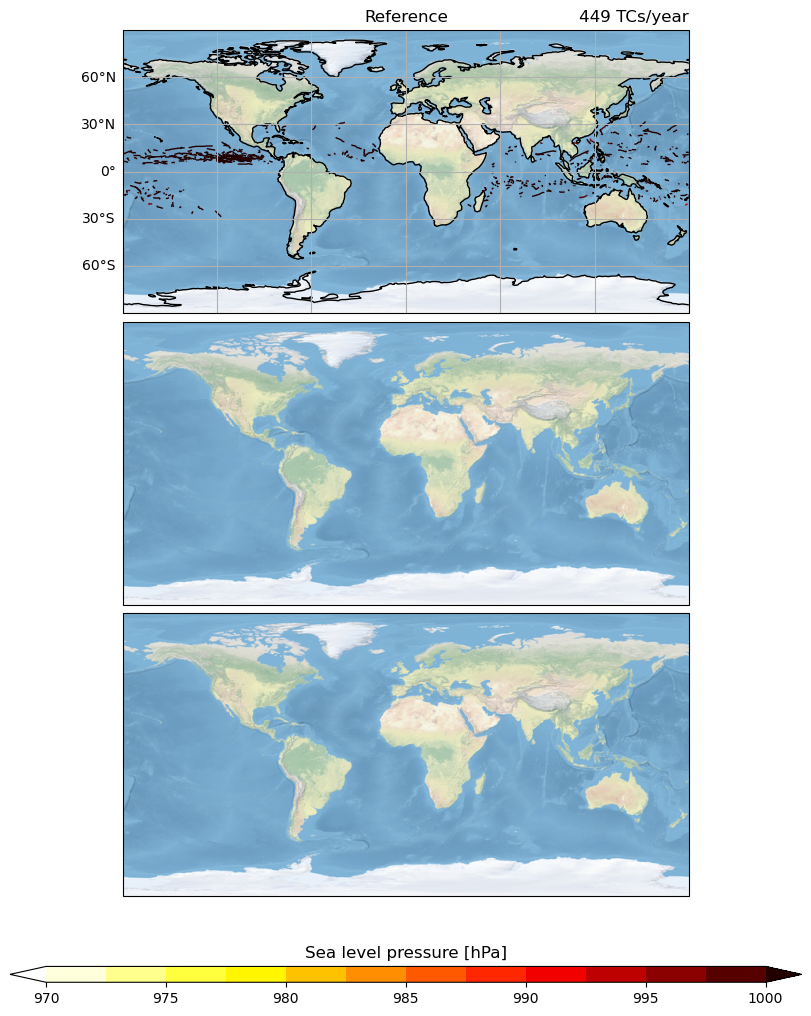

In [5]:

################### track figure #######################

vmin, vmax = 970, 1000
Nv = round((vmax-vmin)/2.5)+1
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')

fig,axs = plt.subplots(3,1,figsize=(8,10), constrained_layout=True, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0),
                                   'xmargin':0.01, 'ymargin':0.01})
for exp, ax in zip(ds, axs):
    #dsi = select_region(ds[exp], dom)
    dsi = ds[exp]
    segments = track_segments(dsi, clevels)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(), capstyle='butt'))
    ax.set_title(exp)
    ax.set_title(f'{dsi.id.size/ds[exp].num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

for ax in axs: # must be after plotting to prevent setting a global view
    ax.stock_img()

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
cb.ax.set_title('Sea level pressure [hPa]')

#savefig(fig, fname, transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'TC seed wind speed (cut off should be 17 m/s)')

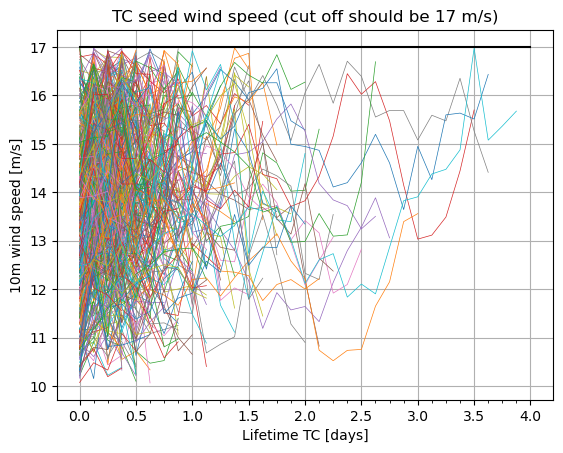

In [6]:
for tid in ds['Reference'].id:
    ds['Reference'].U10.sel(id=tid).plot(lw=0.5)
plt.plot([0,4],[17,17], c='k')
_=plt.xticks(np.arange(0,4,1/8), minor=True)
plt.grid()
plt.title("TC seed wind speed (cut off should be 17 m/s)")

Text(0.5, 1.0, 'histogram count of TC seed track duration')

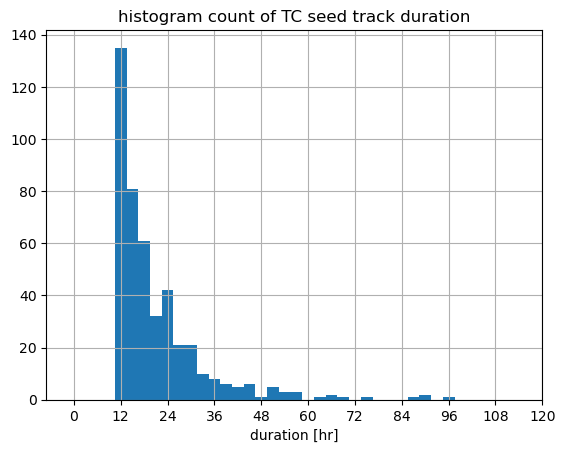

In [7]:
(ds['Reference'].lon.notnull().sum('dtime')*3).plot.hist(bins=range(0,112,3), align='left')
plt.grid()
plt.xlabel('duration [hr]')
plt.xticks(range(0,121,12))
plt.title("histogram count of TC seed track duration")